In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray
import pandas as pd

In [3]:
import sys
sys.path.append('/home/dallaert/tools/a2e-mmc/')

In [4]:
from mmctools.dataloaders import read_dir
from mmctools.wrf.utils import extract_column_from_wrfdata
from mmctools.coupling.internal import SowfaInput
from mmctools.helper_functions import calc_wind

In [5]:
from mmctools.plotting import plot_timehistory_at_height, plot_profile

Define some physical constants

In [6]:
g  = 9.81            # Gravity [m s-2]
T0 = 300             # Reference temperature for perturbation temperature [K]
K  = 0.41            # von Karman constant
R_air = 287.058      # Specific gas constant for dry air [J kg-1 K-1]
Cp_air = 1005        # Specific heat of air [J kg-1 K-1]
P0 = 100000          # Reference pressure [Pa]
kappa = R_air/Cp_air # Poisson constant

# Extract WRF data at a specific site and write as internal forcing for SOWFA

Input files

In [8]:
dpath = '/projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/'
file_filter  = 'mmc_d03_*'

SWIFT site coordinates

In [9]:
site_latitude  = 33.61054
site_longitude = -102.05054

Some parameters for extracting site data

In [10]:
# Define how WRF data is filtered to site specific data
# - 'interpolate': interpolate to site coordinates
# - 'nearest': use nearest WRF grid point
# - 'average': average of an area L_filter x Lfilter centred around the site
spatial_filter = 'interpolate'
L_filter = 0.0

# Define microscale vertical grid
Ztop = 2000.0 # Column height [m]
Vres = 5.0    # Vertical resolution [m]

## Read WRF data

In [11]:
%%time
xa = read_dir(dpath, file_filter=file_filter,
              reader=extract_column_from_wrfdata,
              verbose=True,
              coords=(site_latitude,site_longitude),
              spatial_filter=spatial_filter,L_filter=L_filter,
              Ztop=Ztop,Vres=Vres,
             )

Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_00:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_01:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_02:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_03:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_04:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_05:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_06:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_07:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_08:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_09:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_10:00:00
Reading /p

In [12]:
xa.to_dataframe().head()

U10      V10          T2         TSK     UST  \
Time       height                                                      
2013-11-08 0.0     0.476012  4.92231  284.730592  282.509581  0.0001   
           5.0     0.476012  4.92231  284.730592  282.509581  0.0001   
           10.0    0.476012  4.92231  284.730592  282.509581  0.0001   
           15.0    0.476012  4.92231  284.730592  282.509581  0.0001   
           20.0    0.476012  4.92231  284.730592  282.509581  0.0001   

                           PSFC  HFX   LH  MUU  MUV  ...  RU_TEND_ADV  \
Time       height                                    ...                
2013-11-08 0.0     91081.063181  0.0  0.0  0.0  0.0  ...          0.0   
           5.0     91081.063181  0.0  0.0  0.0  0.0  ...          0.0   
           10.0    91081.063181  0.0  0.0  0.0  0.0  ...          0.0   
           15.0    91081.063181  0.0  0.0  0.0  0.0  ...          0.0   
           20.0    91081.063181  0.0  0.0  0.0  0.0  ...          0.0   

                   RU_TEND_PGF  RU_TEND_COR  RU_TEND_PHYS  RV_TEND  \
Time       height                                                    
2013-11-08 0.0             0.0          0.0           0.0      0.0   
           5.0             0.0          0.0           0.0      0.0   
           10.0            0.0          0.0           0.0      0.0   
           15.0            0.0          0.0           0.0      0.0   
           20.0            0.0          0.0           0.0      0.0   

                   RV_TEND_ADV  RV_TEND_PGF  RV_TEND_COR  RV_TEND_PHYS  \
Time       height                                                        
2013-11-08 0.0             0.0          0.0          0.0           0.0   
           5.0             0.0          0.0          0.0           0.0   
           10.0            0.0          0.0          0.0           0.0   
           15.0            0.0          0.0          0.0           0.0   
           20.0            0.0          0.0          0.0           0.0   

                   T_TEND_ADV  
Time       height              
2013-11-08 0.0            0.0  
           5.0            0.0  
           10.0           0.0  
           15.0           0.0  
           20.0           0.0  

[5 rows x 26 columns]

## Process data

In [13]:
# Round timestamp to 10min
xa['Time'] = xa['Time'].dt.round('10min')

Rescale tendencies with MU*

In [14]:
fieldnames_muu = ['RU_TEND','RU_TEND_ADV','RU_TEND_PGF','RU_TEND_COR','RU_TEND_PHYS']
fieldnames_muv = ['RV_TEND','RV_TEND_ADV','RV_TEND_PGF','RV_TEND_COR','RV_TEND_PHYS']
fieldnames_mut = ['T_TEND_ADV',]
for field in fieldnames_muu:
    xa[field].values = xa[field].values/xa['MUU'].values[:,np.newaxis]
for field in fieldnames_muv:
    xa[field].values = xa[field].values/xa['MUV'].values[:,np.newaxis]
for field in fieldnames_mut:
    xa[field].values = xa[field].values/xa['MUT'].values[:,np.newaxis]

/home/dallaert/.conda-envs/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/dallaert/.conda-envs/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/dallaert/.conda-envs/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Compute additional surface parameters

In [15]:
rho = xa['PSFC'] / (R_air*xa['T2'])

# Kinematic heat flux
xa['wt']  = xa['HFX'] / (Cp_air*rho)
xa['wt'].attrs['description'] = 'kinematic heat flux'
xa['wt'].attrs['units'] = 'K m s-1'

# Obukhov length
xa['L0']  = -xa['UST']**3 * xa['T2'] / (K * g * xa['wt'])
xa['L0'].attrs['description'] = 'Obukhov length'
xa['L0'].attrs['units'] = 'm'

Compute potential temperature from T2 and TSK

In [16]:
# Surface skin potential temperature
xa['thetaSK'] = xa['TSK'] * (P0/xa['PSFC'])**kappa
xa['thetaSK'].attrs['desccription'] = 'surface skin potential temperature'
xa['thetaSK'].attrs['units'] = 'K'

# Potential temperature at 2 m
xa['theta2'] = xa['T2'] * (P0/xa['PSFC'])**kappa
xa['theta2'].attrs['desccription'] = 'potential temperature at 2 m'
xa['theta2'].attrs['units'] = 'K'

Apply temporal averaging (currently not used)

## Write data as SOWFA input file

In [17]:
dateref = '2013-11-08 00:00:00'
datefrom = '2013-11-08 12:00:00'
dateto = '2013-11-09 12:00:00'

In [18]:
dirout = 'drivingData/wrf/'

In [19]:
# Generate dataframe with U, V, W, theta and their tendencies
xa['FU'] = xa['RU_TEND_PGF'] + xa['RU_TEND_ADV']
xa['FV'] = xa['RV_TEND_PGF'] + xa['RV_TEND_ADV']

df = xa.to_dataframe().loc[:,['U','V','W','theta','FU','FV','T_TEND_ADV']].reset_index()
df.rename(index=str, columns={"Time": "datetime"},inplace=True)
df.set_index('datetime',inplace=True)

In [20]:
%%time
to_sowfa = SowfaInput(dirout,df,dateref,datefrom,dateto)
to_sowfa.write_ICs('initialValues',xmom='U',ymom='V',temp='theta')
to_sowfa.write_timeheight('fieldTable',xmom='U',ymom='V',zmom='W',temp='theta')
to_sowfa.write_timeheight('forcingTable',xmom='FU',ymom='FV',zmom='FW',temp='T_TEND_ADV')
#Note: FW does not exist so will be set to zero

CPU times: user 424 ms, sys: 6.65 ms, total: 431 ms
Wall time: 504 ms


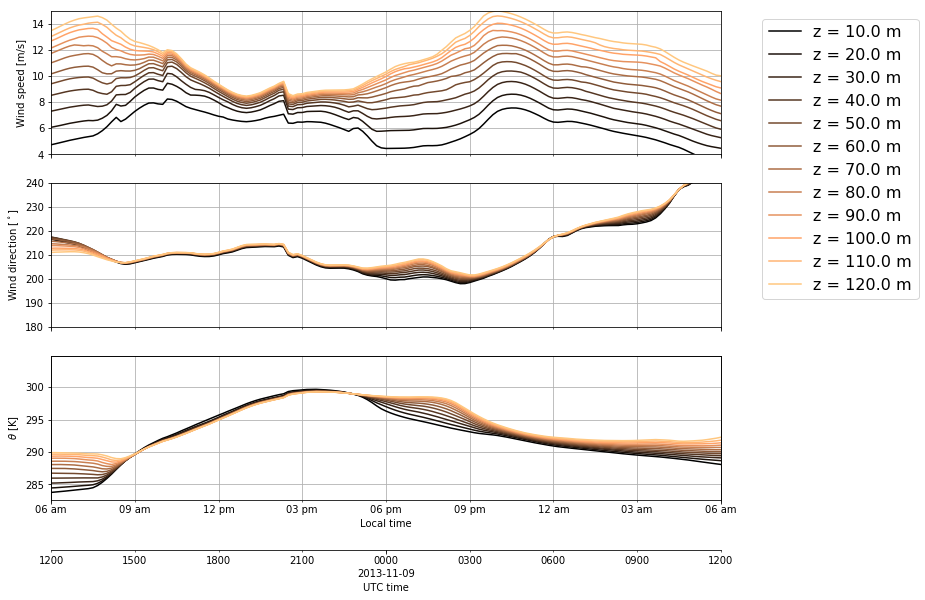

In [21]:
df['wspd'], df['wdir'] = calc_wind(df,'U','V')
fig,ax,ax2 = plot_timehistory_at_height(
    df,
    fields=['wspd','wdir','theta'],
    heights=np.linspace(10,120,12),
    cmap='copper',
    timelimits=['2013-11-08 12:00','2013-11-09 12:00'],
    fieldlimits={'wspd':(4,15),'wdir':(180,240)},
    plot_local_time=True,
    local_time_offset=-6
)

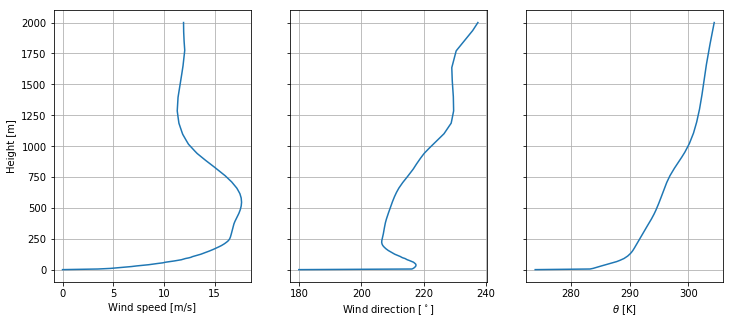

In [22]:
fig,ax = plot_profile(
    df,
    fields=['wspd','wdir','theta'],
    times='2013-11-08 12:00',
    fieldlabels={'theta':r'$\theta$ [K]'},
    showlegend=False
)

In [23]:
# Generate dataframe with surface parameters
df_bc = xa.to_dataframe().loc[:,['TSK','T2','thetaSK','theta2','wt']].reset_index()
df_bc.rename(index=str, columns={"Time": "datetime"},inplace=True)
df_bc.set_index('datetime',inplace=True)
df_bc = df_bc.loc[df_bc.height==0].copy()

In [24]:
%%time
to_sowfabc = SowfaInput(dirout,df_bc,dateref,datefrom,dateto)
to_sowfabc.write_BCs('surfaceSkinTemperatureTable',fieldname='TSK')
to_sowfabc.write_BCs('surface2mTemperatureTable',fieldname='T2')
to_sowfabc.write_BCs('surfaceSkinPotentialTemperatureTable',fieldname='thetaSK')
to_sowfabc.write_BCs('surface2mPotentialTemperatureTable',fieldname='theta2')
to_sowfabc.write_BCs('surfaceTemperatureFluxTable',fieldname='wt',fact=-1.0)

CPU times: user 11.9 ms, sys: 953 µs, total: 12.9 ms
Wall time: 119 ms


In [25]:
df_bc.head()

,height,TSK,T2,thetaSK,theta2,wt
datetime,,,,,,
2013-11-08 00:00:00,0.0,282.509581,284.730592,290.149435,292.430509,0.000000
2013-11-08 00:10:00,0.0,281.332753,283.019061,288.926583,290.658409,-0.029108
2013-11-08 00:20:00,0.0,280.621010,282.173687,288.216289,289.810991,-0.018391
2013-11-08 00:30:00,0.0,280.373953,281.783222,287.949704,289.397052,-0.018704
2013-11-08 00:40:00,0.0,280.020192,281.410004,287.618265,289.045789,-0.016355


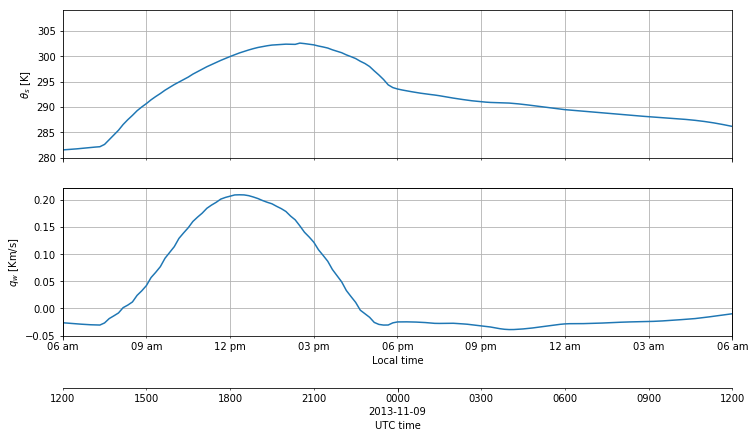

In [26]:
fig,ax,ax2 = plot_timehistory_at_height(
    df_bc,
    fields=['thetaSK','wt'],
    heights=0.0,
    timelimits=['2013-11-08 12:00','2013-11-09 12:00'],
    fieldlabels={'thetaSK':r'$\theta_s$ [K]','wt':r'$q_w$ [Km/s]'},
    showlegend=False,
    plot_local_time=True,
    local_time_offset=-6
)